# MicroGrad
- A mini Autograd engine to implement backpropagation.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivatives

- How much does output change for small changes in input
\begin{align*}
  {\Delta y \over \Delta x}
\end{align*}
- The general formula for derivative is:
\begin{align*}
  \lim_{h \to 0}\frac{f(x+h) - f(x)}{h}
\end{align*}

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

# derivative is "6x - 4"

In [4]:
f(3.0)

20.0

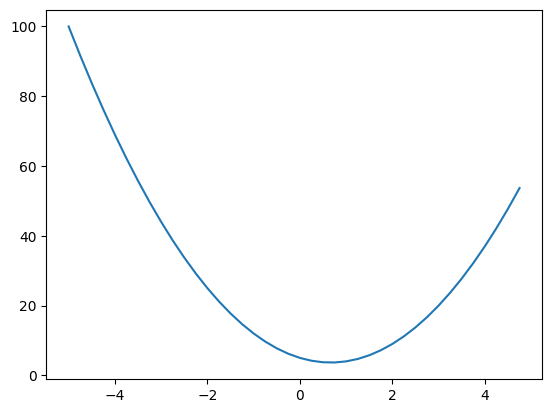

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 2/3

In [7]:
# Derivative
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [8]:
# lets go more complex (multiple input)
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [9]:
h = 0.0001

a, b, c = 2.0, -3.0, 10.0

d1 = a*b+c
b += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


## Creating Value Class

In [10]:
class Value:
    def __init__(self, data, _children=(), op='', label=''):
        self.label = label
        self.data = data
        self.grad = 0.0
        
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = op

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self, other), op='+')

        def _backward(): # grads add up
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), op='*')

        def _backward(): # grads add up
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int, float values" 
        out = Value(self.data**other, (self, ), op='pow')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = math.exp(x) * out.grad

        out._backward = _backward
        return out

    
    def backward(self):
        """ 
        implements back propagation using topological
        sorting for whole math expresssion graph
        """

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()




a = Value(2.0, label='a')
b = Value(-3, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d*f; L.label= 'L'
L


Value(data=-8.0)

In [11]:
x = Value(1, label='x')
3 * x

Value(data=3)

### Function to draw Graph

In [12]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### Draw Graph

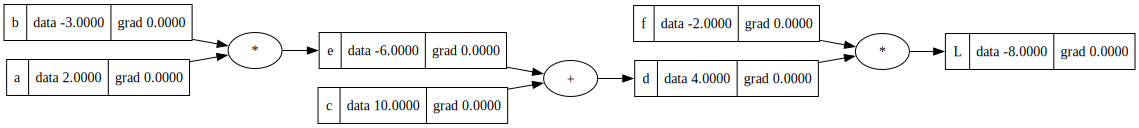

In [13]:
draw_dot(L)

## Manual Back Propagation

In [14]:
L.grad = 1.0

f.grad = 4.0     # value of d
d.grad = -2.0    # value of f

# d = c + e
c.grad = -2      # d.grad * dd/dc
e.grad = -2      # d.grad * dd/de

# e = a * b
a.grad = (-2.0 * -3.0)     # e.grad * de/da
b.grad = (-2.0 * 2.0)      # e.grad * de/db


In [15]:
# nudge leaf nodes(a, b, c, f) in direction of gradient

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d*f

L.data

-7.286496

In [16]:
def test():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label= 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label= 'L'
    L2 = L.data
    
    return (L2-L1)/h

test()

-3.9999999999995595

## Neuron BackPropagation

#### Tanh function

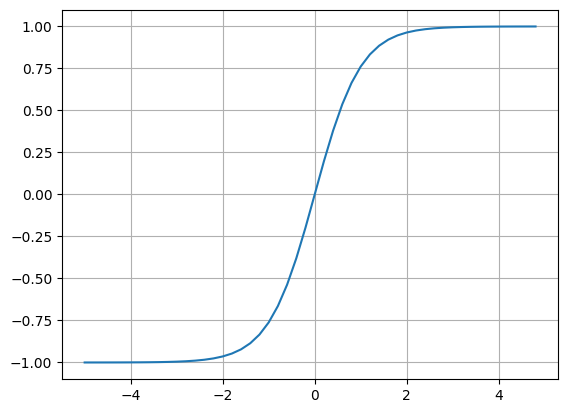

In [17]:
xs = np.arange(-5, 5, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)
plt.grid()

### Weights And Biases

##### Manual Back Prop

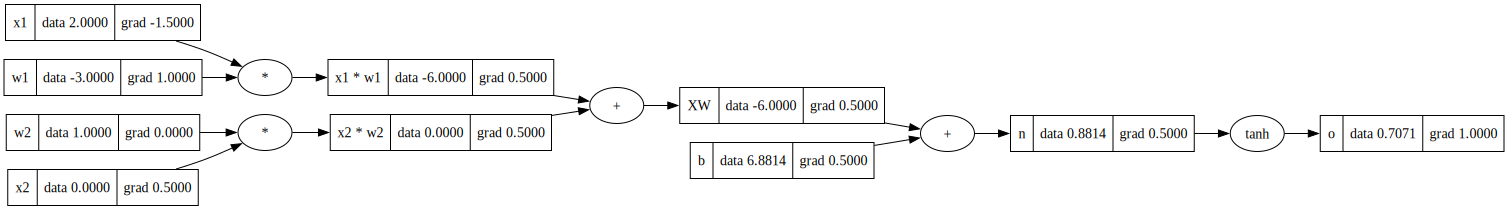

In [18]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of neuron
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1 * w1"
x2w2 = x2*w2; x2w2.label = "x2 * w2"

XW = x1w1 + x2w2; XW.label = 'XW'
n = XW + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.grad = 1.0


# --------------------------------------------------------
# MANUAL BACK PROPAGATION
# -----------------------------------------------------


# o = tanh(n)
# do/dn => 1 - tanh(n)**2 => 1 - o**2

n.grad = 0.5 # do/dn

XW.grad = 0.5    # dn/dXW * n.grad
b.grad = 0.5     # dn/db  * n.grad

x1w1.grad = 0.5  # dXW/dx1 * XW.grad
x2w2.grad = 0.5  # dXW/dx2 * XW.grad

x1.grad = x1w1.grad * w1.data  # x1w1.grad * dx1w1/dx1
w1.grad = x1w1.grad * x1.data  # x1w1.grad * dx1w1/dw1

x2.grad = x2w2.grad * w2.data  # x2w2.grad * dx2w2/dx2 
w2.grad = x2w2.grad * x2.data  # x2w2.grad * dx2w2/dw2

draw_dot(o)

##### Using Tanh directly

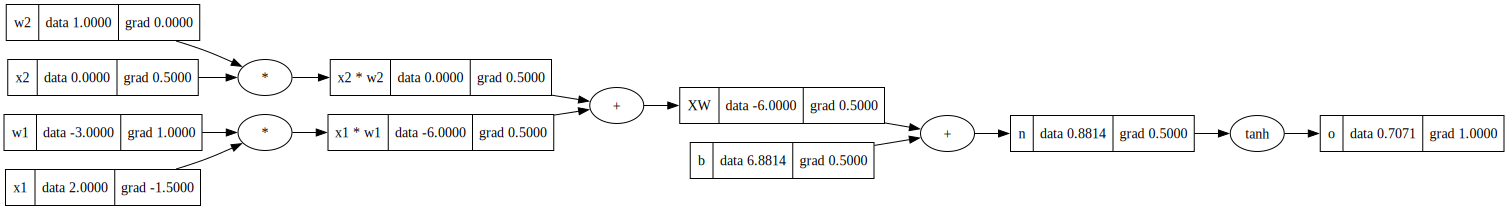

In [19]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of neuron
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1 * w1"
x2w2 = x2*w2; x2w2.label = "x2 * w2"

XW = x1w1 + x2w2; XW.label = 'XW'
n = XW + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

##### Deriving tanh then use it

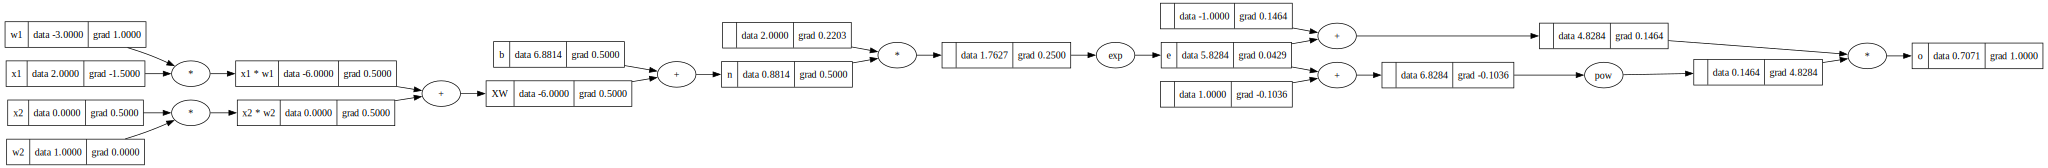

In [20]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of neuron
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1 * w1"
x2w2 = x2*w2; x2w2.label = "x2 * w2"

XW = x1w1 + x2w2; XW.label = 'XW'
n = XW + b; n.label = 'n'

# --------
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1)
# --------

o.label = 'o'
o.backward()
draw_dot(o)

## Same with Pytorch

In [21]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b   # neuron
o = torch.tanh(n)       # activation

print(o.data.item())
o.backward()

print("----")
print("x1:", x1.grad.item())
print("w1:", w1.grad.item())
print("x2:", x2.grad.item())
print("w2:", w2.grad.item())

0.7071066904050358
----
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0


## Creating Neuron

In [31]:
np.random.uniform(-1, 1)

0.5219481405440718

In [32]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        # x*w + b
        summ = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = summ.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs   
    
    def parameters(self):
        # return [ n.parameters() for n in self.neurons ]
        return [ p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # return [ l.parameters() for l in self.layers ]
        return [ p for l in self.layers for p in l.parameters()]

In [82]:
x = [1.0, 2.0, 3.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.26075467799814606)

In [83]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 3.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired / true Targets

## Back Propagation of Nerual Network

In [88]:
for k in range(20):

    # forward pass
    y_pred = [mlp(xi) for xi in xs]
    loss = sum([(y_out-y_true)**2 for y_true, y_out in zip(ys, y_pred)], Value(0))

    # backward pass
    for p in mlp.parameters(): # zero grad
        p.grad = 0.0
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += (-0.01 * p.grad)
    
    print(k, loss.data)

0 0.1314212173502472
1 0.12711806862549863
2 0.12306328380660596
3 0.11923699348701673
4 0.11562131988451871
5 0.1122001403729375
6 0.1089588830956782
7 0.10588434981147937
8 0.10296456192424501
9 0.10018862630765102
10 0.09754661807840567
11 0.0950294779211798
12 0.0926289219407327
13 0.0903373623265495
14 0.08814783737373766
15 0.08605394962007586
16 0.08404981104041827
17 0.0821299943921415
18 0.08028948993391537
19 0.0785236668487987


In [89]:
y_pred

[Value(data=0.8554661517542649),
 Value(data=-0.8281712684910874),
 Value(data=-0.8832685232870784),
 Value(data=0.8796576428162712)]